In [1]:
import sys

sys.path.append('../poligrain/src')
sys.path.append('../mergeplg/src')

import poligrain as plg
import mergeplg as mrg

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## Create synthetic example rainfall field and radar observation

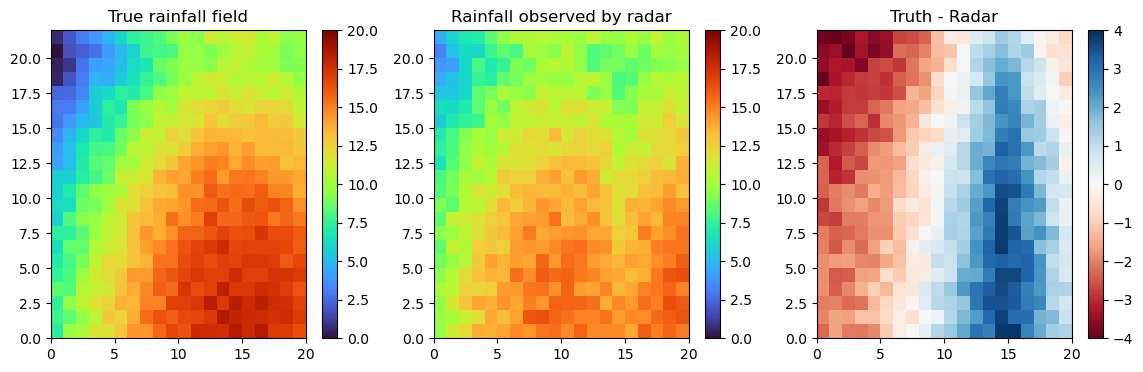

In [2]:
# grid axes
x = np.arange(0, 20)
y = np.arange(0, 22)
x_grid, y_grid = np.meshgrid(x, y)

np.random.seed(13196840)

# Synthetic true rainfall
truth = (
    np.abs(10.0 * np.sin(0.11 * x_grid))
    + np.abs(8.0 * np.cos(0.08 * y_grid))
    )
truth = truth + 0.8 * np.random.uniform(low=-1.0, high=1, size=x_grid.shape)

# Creating radar data by perturbing truth
radar = truth.copy()
radar = 1.0 * truth + 0.5 * np.random.uniform(low=-1.0, high=1, size=x_grid.shape)
radar = (
    radar 
    + np.abs(6 * np.cos(0.11 * x_grid))
    - np.abs(3 * np.cos(0.06  * y_grid))
)
radar = radar - 1
radar[radar < 0.0] = 0.0


vmin, vmax = 0, 20
cmap = 'turbo'
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].set_title('True rainfall field')
pc = axs[0].pcolormesh(truth, vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(pc)
axs[1].set_title('Rainfall observed by radar')
pc = axs[1].pcolormesh(radar, vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(pc)
axs[2].set_title('Truth - Radar')
pc = axs[2].pcolormesh(truth - radar, vmin=vmax * -0.2, vmax=vmax * 0.2, cmap='RdBu')
plt.colorbar(pc);



In [3]:
ds_radar = xr.Dataset(
    data_vars={
        'R_observed': ( ['y', 'x'], radar),
        'R_true': (['y',  'x'], truth),
    },
    coords={
        'x_grid': (['y', 'x'], x_grid),
        'y_grid':  (['y',   'x'], y_grid),
    },
)


## Radar-gauge adjustment

### Create synthetic gauge observations

In [ ]:
ds_gauges = xr.Dataset(
    data_vars={
        # dummy data, because we need gauge observations in GridAtPoints
        'R_init': (['id'], [0, 0, 0, 0]),
    },
    coords={
        'x': (('id'), [2, 16, 3, 6]),
        'y':  (['id'], [2, 5, 13, 6]),
        'lon': (('id'), [2, 16, 3, 6]),
        'lat':  (['id'], [2, 5, 13, 6]),
    },
)

In [11]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_radar,
    da_point_data=ds_gauges,
    nnear=1,
    use_lon_lat=False,
)

ds_gauges['R'] = get_grid_at_points(
    da_gridded_data=ds_radar.R_true,
    da_point_data=ds_gauges.R_init,
)
ds_gauges = ds_gauges.drop_vars('R_init')

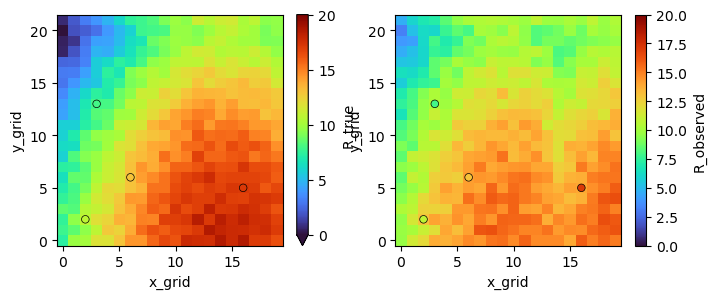

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_true, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=20,
    kwargs_gauges_plot={"s": 30},
    ax=axs[0],
)

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_observed, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=20,
    kwargs_gauges_plot={"s": 30},
    ax=axs[1],
);

### Additive adjustment with IDW interpolation

#### Calculate differencence between gauge data and radar data at gauge location

In [7]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_radar,
    da_point_data=ds_gauges,
    nnear=1,
    use_lon_lat=False,
)

ds_gauges['R_radar'] = get_grid_at_points(
    da_gridded_data=ds_radar.R_observed,
    da_point_data=ds_gauges.R,
)

ds_gauges['R_diff'] = ds_gauges.R - ds_gauges.R_radar

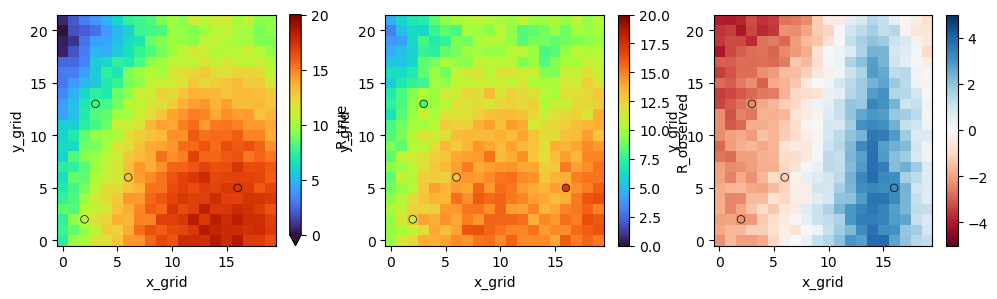

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_true, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=20,
    kwargs_gauges_plot={"s": 30},
    ax=axs[0],
)

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_observed, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=20,
    kwargs_gauges_plot={"s": 30},
    ax=axs[1],
)

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_true - ds_radar.R_observed, 
    da_gauges=ds_gauges.R_diff,
    use_lon_lat=False,
    vmin=-5,
    vmax=5,
    cmap='RdBu',
    kwargs_gauges_plot={"s": 30},
    ax=axs[2],
);

#### Spatial interpolation of differences

In [9]:
idw_interpolator = mrg.interpolate.InterpolateIDW(min_observations=2)

R_grid_idw = idw_interpolator.interpolate(
            da_grid=ds_radar.expand_dims('time'),
            da_gauge=ds_gauges.R_diff.expand_dims('time'),
            p=3,
            idw_method='standard',
        ).isel(time=0)

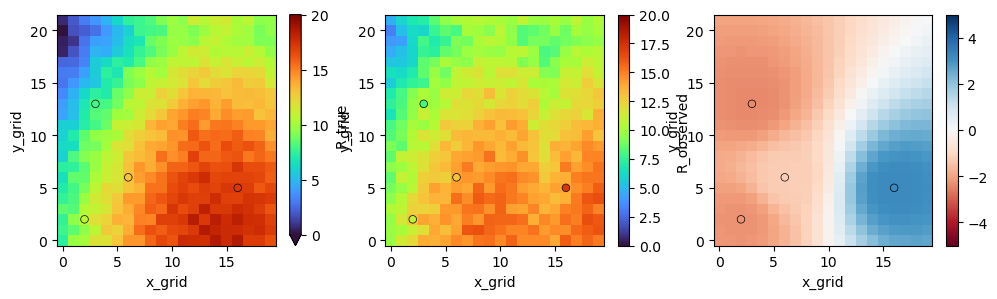

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_true, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=20,
    kwargs_gauges_plot={"s": 30},
    ax=axs[0],
)

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_observed, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=20,
    kwargs_gauges_plot={"s": 30},
    ax=axs[1],
)

plg.plot_map.plot_plg(
    da_grid=R_grid_idw, 
    da_gauges=ds_gauges.R_diff,
    use_lon_lat=False,
    vmin=-5,
    vmax=5,
    cmap='RdBu',
    kwargs_gauges_plot={"s": 30},
    ax=axs[2],
);

#### Adjust radar field with interpolated diff field

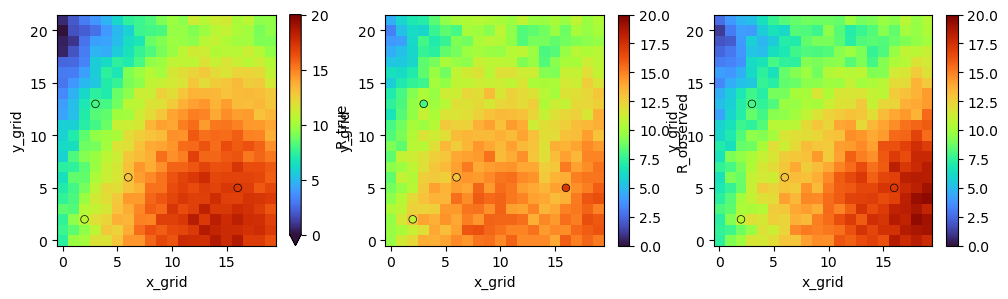

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_true, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=20,
    kwargs_gauges_plot={"s": 30},
    ax=axs[0],
)

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_observed, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=20,
    kwargs_gauges_plot={"s": 30},
    ax=axs[1],
)

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_observed + R_grid_idw, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=20,
    kwargs_gauges_plot={"s": 30},
    ax=axs[2],
);

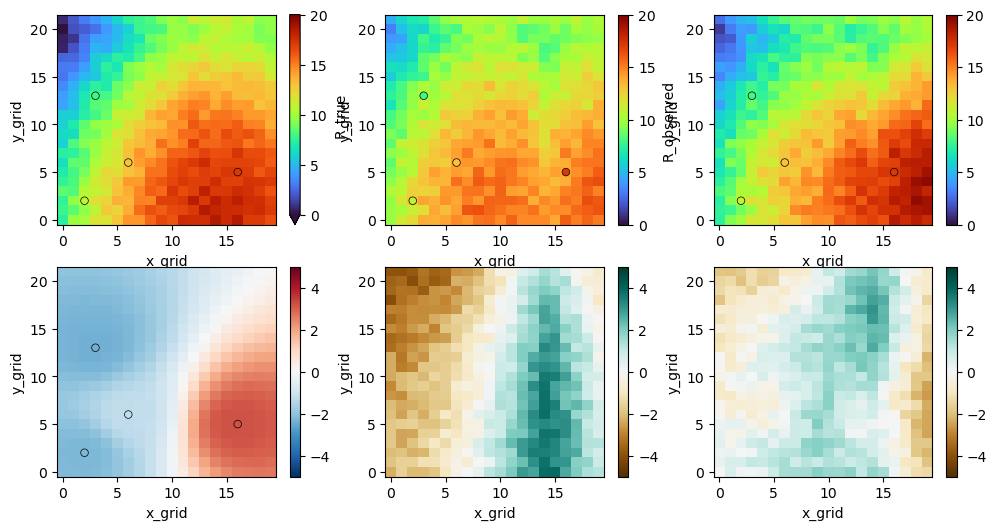

In [12]:
def plot_radar_fields_and_gauges(
    da_grid_R_true,
    da_grid_R_observed,
    da_grid_R_adjusted,
    da_gauges_R=None,
    da_cmls_R=None,
    da_gauges_R_diff=None,
    da_cmls_R_diff=None,
):

    fig, axs = plt.subplots(2, 3, figsize=(12, 6))

    plg.plot_map.plot_plg(
        da_grid=da_grid_R_true,
        da_gauges=da_gauges_R,
        da_cmls=da_cmls_R,
        use_lon_lat=False,
        vmin=0,
        vmax=20,
        kwargs_gauges_plot={"s": 30},
        ax=axs[0, 0],
    )

    plg.plot_map.plot_plg(
        da_grid=da_grid_R_observed,
        da_gauges=da_gauges_R,
        da_cmls=da_cmls_R,
        use_lon_lat=False,
        vmin=0,
        vmax=20,
        kwargs_gauges_plot={"s": 30},
        ax=axs[0, 1],
    )

    plg.plot_map.plot_plg(
        da_grid=da_grid_R_adjusted,
        da_gauges=da_gauges_R,
        da_cmls=da_cmls_R,
        use_lon_lat=False,
        vmin=0,
        vmax=20,
        kwargs_gauges_plot={"s": 30},
        ax=axs[0, 2],
    )

    plg.plot_map.plot_plg(
        da_grid=da_grid_R_adjusted - da_grid_R_observed,
        da_gauges=da_gauges_R_diff,
        da_cmls=da_cmls_R_diff,
        use_lon_lat=False,
        vmin=-5,
        vmax=5,
        cmap="RdBu_r",
        kwargs_gauges_plot={"s": 30},
        ax=axs[1, 0],
    )

    plg.plot_map.plot_plg(
        da_grid=da_grid_R_true - da_grid_R_observed,
        use_lon_lat=False,
        vmin=-5,
        vmax=5,
        cmap="BrBG",
        kwargs_gauges_plot={"s": 30},
        ax=axs[1, 1],
    )

    plg.plot_map.plot_plg(
        da_grid=da_grid_R_true - da_grid_R_adjusted,
        use_lon_lat=False,
        vmin=-5,
        vmax=5,
        cmap="BrBG",
        kwargs_gauges_plot={"s": 30},
        ax=axs[1, 2],
    )


plot_radar_fields_and_gauges(
    da_grid_R_true=ds_radar.R_true,
    da_grid_R_observed=ds_radar.R_observed,
    da_grid_R_adjusted=ds_radar.R_observed + R_grid_idw,
    da_gauges_R=ds_gauges.R,
    da_gauges_R_diff=ds_gauges.R_diff,
)

In [13]:
idw_interpolator = mrg.interpolate.InterpolateIDW(min_observations=2)

R_grid_idw = idw_interpolator.interpolate(
            da_grid=ds_radar.expand_dims('time'),
            da_gauge=ds_gauges.R_diff.expand_dims('time'),
            p=3,
            idw_method='standard',
        ).isel(time=0)

plot_radar_fields_and_gauges(
    da_grid_R_true=ds_radar.R_true,
    da_grid_R_observed=ds_radar.R_observed,
    da_grid_R_adjusted=ds_radar.R_observed + R_grid_idw,
    ds_gauges_R=ds_gauges.R,
)

TypeError: plot_radar_fields_and_gauges() got an unexpected keyword argument 'ds_gauges_R'

### Additive adjustment with Ordinary Kriging interpolation

Here we reuse the differencence between radar and gauge that we already calculated above.

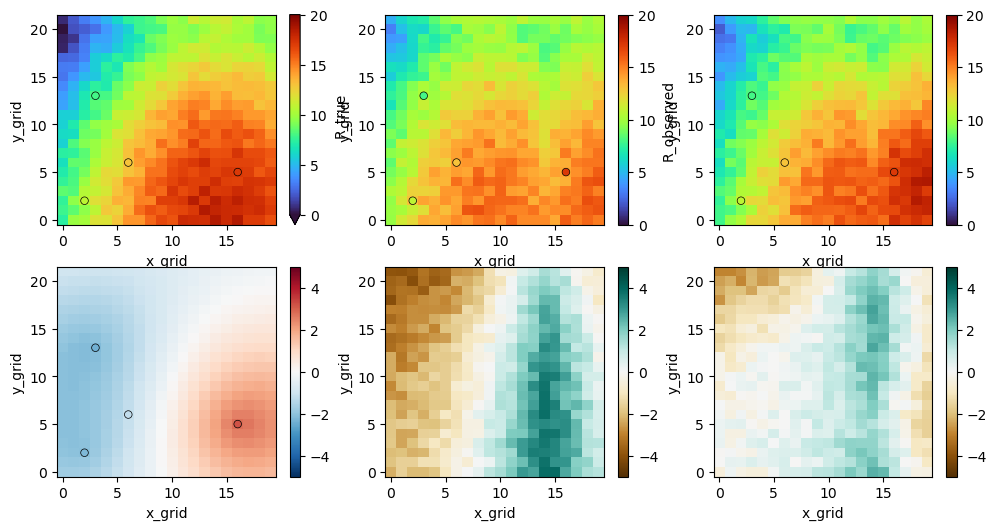

In [ ]:
ok_interpolator = mrg.interpolate.InterpolateOrdinaryKriging(min_observations=2)

R_grid_idw = ok_interpolator.interpolate(
            da_grid=ds_radar.expand_dims('time'),
            da_gauge=ds_gauges.R_diff.expand_dims('time'),
            variogram_parameters = {"sill": 1, "range": 20, "nugget": 0.1}
        ).isel(time=0)

plot_radar_fields_and_gauges(
    da_grid_R_true=ds_radar.R_true,
    da_grid_R_observed=ds_radar.R_observed,
    da_grid_R_adjusted=ds_radar.R_observed + R_grid_idw,
    da_gauges_R=ds_gauges.R,
)

### Ex 1: Play with different variants of radar-gauge adjustment

- Ex1.1: Change IDW parameteres and look at the results
- Ex1.2: Change the variogram parameters and look at the results
- Ex1.3: Do multiplicative adjustment insteand of additive adjustment

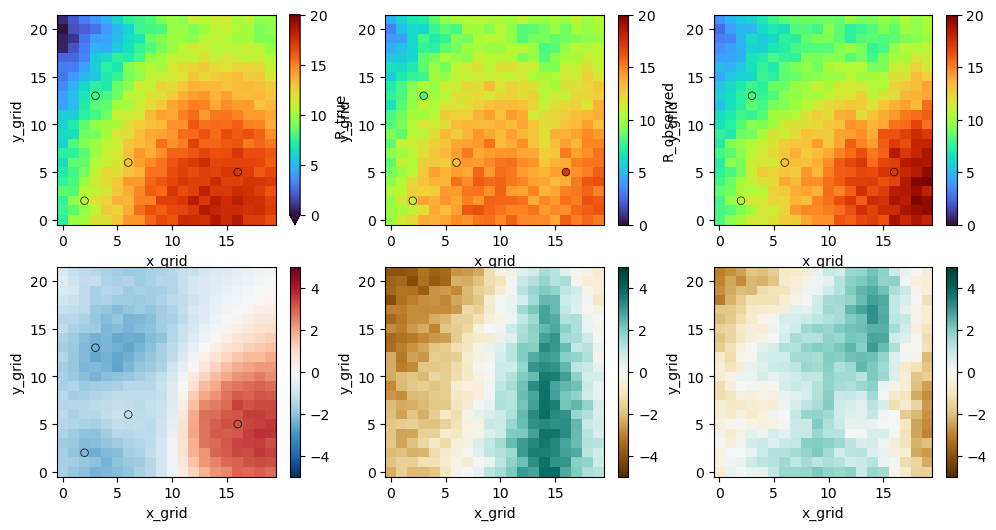

In [ ]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_radar,
    da_point_data=ds_gauges,
    nnear=1,
    use_lon_lat=False,
)

ds_gauges['R_radar'] = get_grid_at_points(
    da_gridded_data=ds_radar.R_observed,
    da_point_data=ds_gauges.R,
)

ds_gauges['R_fact'] = ds_gauges.R / ds_gauges.R_radar

idw_interpolator = mrg.interpolate.InterpolateIDW(min_observations=2)

R_grid_idw = idw_interpolator.interpolate(
            da_grid=ds_radar.expand_dims('time'),
            da_gauge=ds_gauges.R_fact.expand_dims('time'),
            p=3,
            idw_method='standard',
        ).isel(time=0)

plot_radar_fields_and_gauges(
    da_grid_R_true=ds_radar.R_true,
    da_grid_R_observed=ds_radar.R_observed,
    da_grid_R_adjusted=ds_radar.R_observed * R_grid_idw,
    da_gauges_R=ds_gauges.R,
)

## Radar-CML adjustment

### Create synthetic CML observations

In [ ]:
site_0_x = [19, 2, 2, 12]
site_0_y = [8, 10, 10, 14]
site_1_x = [9, 4, 3, 12.4]
site_1_y = [6, 6.2, 0.3, 14.3]

cml_ids = [f'cml{i}' for i in range(len(site_0_x))]

ds_cmls = xr.Dataset(
    coords={
        'site_0_lon': (["cml_id"], site_0_x),
        'site_1_lon': (["cml_id"], site_1_x),
        'site_0_lat': (["cml_id"], site_0_y),
        'site_1_lat': (["cml_id"], site_1_y),
        'site_0_x': (["cml_id"], site_0_x),
        'site_1_x': (["cml_id"], site_1_x),
        'site_0_y': (["cml_id"], site_0_y),
        'site_1_y': (["cml_id"], site_1_y),
    },
)

ds_cmls

<xarray.Dataset> Size: 256B
Dimensions:     (cml_id: 4)
Coordinates:
    site_0_lon  (cml_id) int64 32B 19 2 2 12
    site_1_lon  (cml_id) float64 32B 9.0 4.0 3.0 12.4
    site_0_lat  (cml_id) int64 32B 8 10 10 14
    site_1_lat  (cml_id) float64 32B 6.0 6.2 0.3 14.3
    site_0_x    (cml_id) int64 32B 19 2 2 12
    site_1_x    (cml_id) float64 32B 9.0 4.0 3.0 12.4
    site_0_y    (cml_id) int64 32B 8 10 10 14
    site_1_y    (cml_id) float64 32B 6.0 6.2 0.3 14.3
Dimensions without coordinates: cml_id
Data variables:
    *empty*

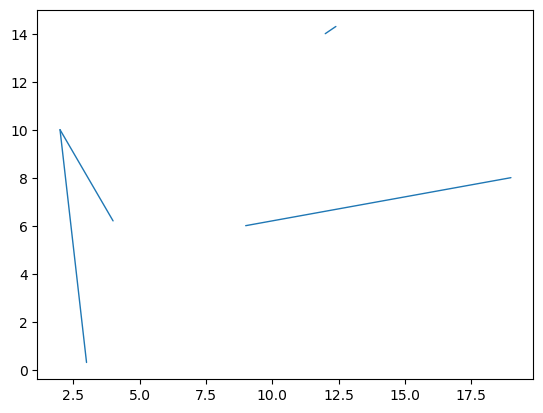

In [ ]:
ds_cmls.plg.plot_cmls()

In [ ]:
ds_cmls = xr.Dataset(
    coords={
        'site_0_lon': (["cml_id"], site_0_x),
        'site_1_lon': (["cml_id"], site_1_x),
        'site_0_lat': (["cml_id"], site_0_y),
        'site_1_lat': (["cml_id"], site_1_y),
        'site_0_x': (["cml_id"], site_0_x),
        'site_1_x': (["cml_id"], site_1_x),
        'site_0_y': (["cml_id"], site_0_y),
        'site_1_y': (["cml_id"], site_1_y),
    },
)

get_grid_at_lines = plg.spatial.GridAtLines(
    da_gridded_data=ds_radar,
    ds_line_data=ds_cmls,
)
ds_cmls

<xarray.Dataset> Size: 256B
Dimensions:     (cml_id: 4)
Coordinates:
    site_0_lon  (cml_id) int64 32B 19 2 2 12
    site_1_lon  (cml_id) float64 32B 9.0 4.0 3.0 12.4
    site_0_lat  (cml_id) int64 32B 8 10 10 14
    site_1_lat  (cml_id) float64 32B 6.0 6.2 0.3 14.3
    site_0_x    (cml_id) int64 32B 19 2 2 12
    site_1_x    (cml_id) float64 32B 9.0 4.0 3.0 12.4
    site_0_y    (cml_id) int64 32B 8 10 10 14
    site_1_y    (cml_id) float64 32B 6.0 6.2 0.3 14.3
Dimensions without coordinates: cml_id
Data variables:
    *empty*

In [ ]:
ds_cmls = xr.Dataset(
    coords={
        'site_0_lon': (["cml_id"], site_0_x),
        'site_1_lon': (["cml_id"], site_1_x),
        'site_0_lat': (["cml_id"], site_0_y),
        'site_1_lat': (["cml_id"], site_1_y),
        'site_0_x': (["cml_id"], site_0_x),
        'site_1_x': (["cml_id"], site_1_x),
        'site_0_y': (["cml_id"], site_0_y),
        'site_1_y': (["cml_id"], site_1_y),
    },
)

get_grid_at_lines = plg.spatial.GridAtLines(
    da_gridded_data=ds_radar,
    ds_line_data=ds_cmls,
)

ds_cmls['R'] = get_grid_at_lines(da_gridded_data=ds_radar.R_true).drop_vars('time') # REMOVE the drop_vars here after updating poligrain
ds_cmls['R_radar'] = get_grid_at_lines(da_gridded_data=ds_radar.R_observed).drop_vars('time')
ds_cmls['R_diff'] = ds_cmls.R - ds_cmls.R_radar

# get_grid_at_lines = plg.spatial.GridAtLines(
#     da_gridded_data=ds_radar,
#     ds_line_data=ds_cmls,
# )
# ds_cmls['R'] = get_grid_at_lines(da_gridded_data=ds_radar.R_true).drop_vars('time')


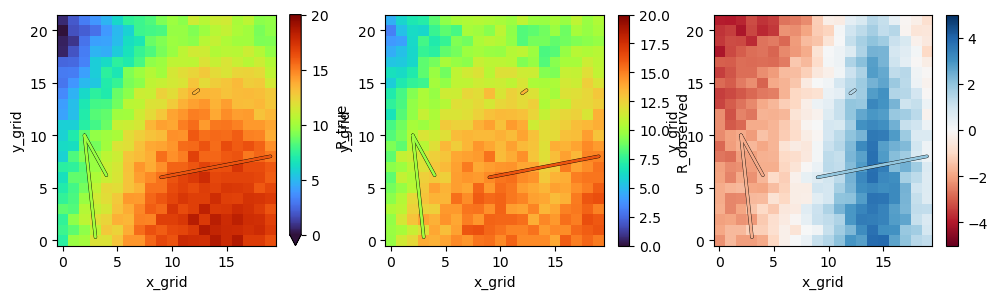

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_true, 
    da_cmls=ds_cmls.R,
    use_lon_lat=False,
    vmin=0,
    vmax=20,
    kwargs_gauges_plot={"s": 30},
    ax=axs[0],
)

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_observed, 
    da_cmls=ds_cmls.R,
    use_lon_lat=False,
    vmin=0,
    vmax=20,
    kwargs_gauges_plot={"s": 30},
    ax=axs[1],
)

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_true - ds_radar.R_observed, 
    da_cmls=ds_cmls.R_diff,
    use_lon_lat=False,
    vmin=-5,
    vmax=5,
    cmap='RdBu',
    kwargs_gauges_plot={"s": 30},
    ax=axs[2],
);

### Additive adjustment with IDW interpolation

We have already calculated the diff of radar and CML above. Now we just have to interpolat the diff field. For IDW, we have to represent each CML path by a synthetic gauge in the middle of its path. This is automatically done in `InterpolateIDW`.

In [ ]:
idw_interpolator = mrg.interpolate.InterpolateIDW(min_observations=2)

R_grid_idw = idw_interpolator.interpolate(
            da_grid=ds_radar.expand_dims('time'),
            da_cml=ds_cmls.R_diff.expand_dims('time'),
            p=3,
            idw_method='standard',
        ).isel(time=0)

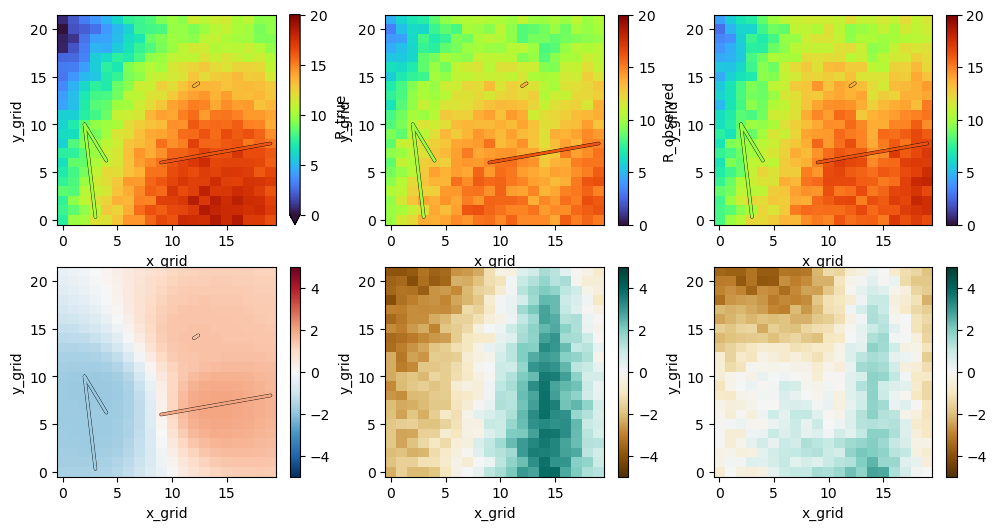

In [ ]:
plot_radar_fields_and_gauges(
    da_grid_R_true=ds_radar.R_true,
    da_grid_R_observed=ds_radar.R_observed,
    da_grid_R_adjusted=ds_radar.R_observed + R_grid_idw,
    da_cmls_R=ds_cmls.R,
    da_cmls_R_diff=ds_cmls.R_diff,
)

### Ex2: Use Block Kriging

- Ex2.1: Use Ordinary Kriging for interpolating CML adjustment field
- Ex2.2: Switch on/off `full_line` option in `.interpolate()`. What do you observe?

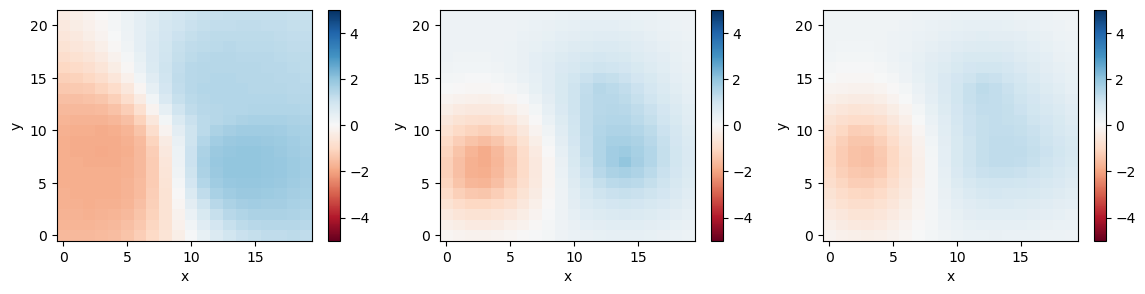

In [ ]:
# solution Ex2.2

ok_interpolator = mrg.interpolate.InterpolateOrdinaryKriging(min_observations=2, discretization=10)

R_grid_ok = ok_interpolator.interpolate(
            da_grid=ds_radar.expand_dims('time'),
            da_cml=ds_cmls.R_diff.expand_dims('time'),
            variogram_parameters = {"sill": 1, "range": 10, "nugget": 0.001},
            full_line=False,
        ).isel(time=0)

R_grid_ok_block = ok_interpolator.interpolate(
            da_grid=ds_radar.expand_dims('time'),
            da_cml=ds_cmls.R_diff.expand_dims('time'),
            variogram_parameters = {"sill": 1, "range": 10, "nugget": 0.1},
            full_line=True,
        ).isel(time=0)

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
R_grid_idw.plot(ax=axs[0], vmin=-5, vmax=5, cmap='RdBu')
R_grid_ok.plot(ax=axs[1], vmin=-5, vmax=5, cmap='RdBu')
R_grid_ok_block.plot(ax=axs[2], vmin=-5, vmax=5, cmap='RdBu')

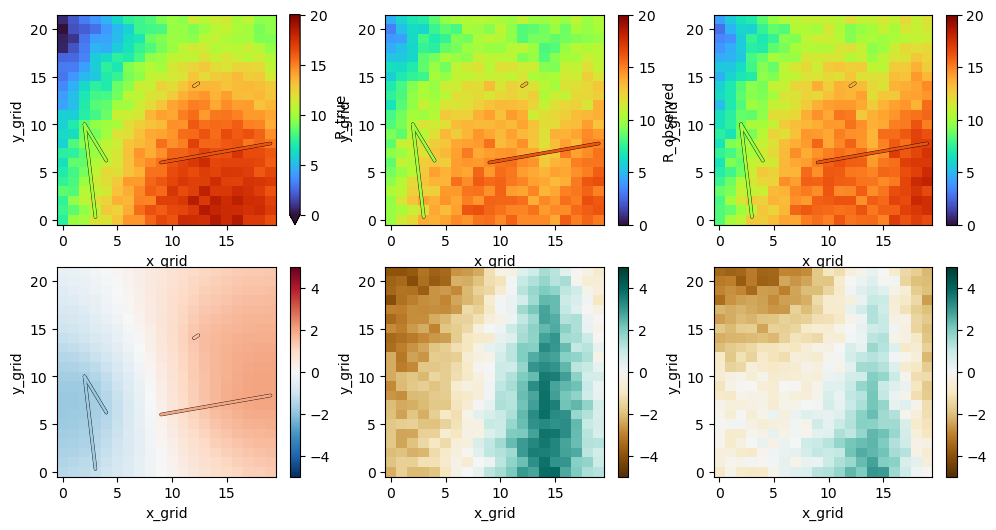

In [ ]:
plot_radar_fields_and_gauges(
    da_grid_R_true=ds_radar.R_true,
    da_grid_R_observed=ds_radar.R_observed,
    da_grid_R_adjusted=ds_radar.R_observed + R_grid_ok_block,
    da_cmls_R=ds_cmls.R,
    da_cmls_R_diff=ds_cmls.R_diff,
)

## Introduction to high-level merging functions

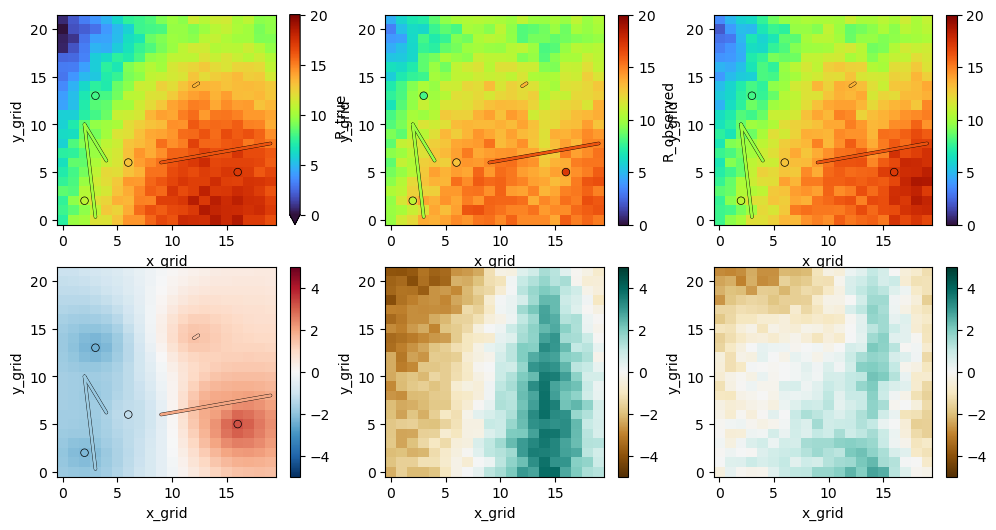

In [ ]:
merger = mrg.merge.MergeDifferenceIDW(min_observations=3)

R_grid_idw_high_level = merger.adjust(
    ds_radar.R_observed.expand_dims('time'),
    da_cml=ds_cmls.R.expand_dims('time'),
    da_gauge=ds_gauges.R.expand_dims('time'),
    idw_method="standard",
    max_distance=50,
).isel(time=0)

plot_radar_fields_and_gauges(
    da_grid_R_true=ds_radar.R_true,
    da_grid_R_observed=ds_radar.R_observed,
    da_grid_R_adjusted=R_grid_idw_high_level,
    da_cmls_R=ds_cmls.R,
    da_gauges_R=ds_gauges.R,
    da_cmls_R_diff=ds_cmls.R_diff,
    da_gauges_R_diff=ds_gauges.R_diff,
)

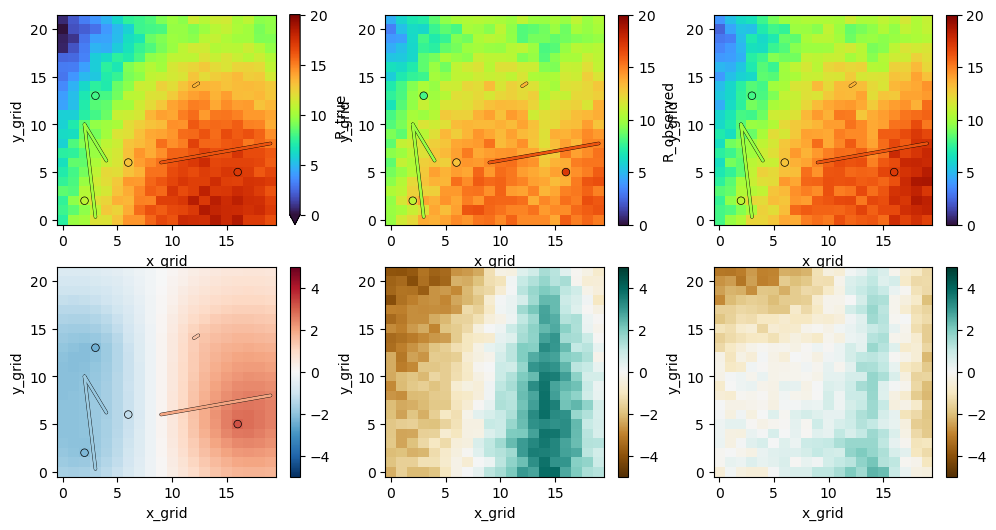

In [ ]:
merger = mrg.merge.MergeDifferenceOrdinaryKriging(min_observations=3)

R_grid_ok_high_level = merger.adjust(
    ds_radar.R_observed.expand_dims('time'),
    da_cml=ds_cmls.R.expand_dims('time'),
    da_gauge=ds_gauges.R.expand_dims('time'),
    variogram_parameters = {"sill": 1, "range": 20, "nugget": 0.1}
).isel(time=0)

plot_radar_fields_and_gauges(
    da_grid_R_true=ds_radar.R_true,
    da_grid_R_observed=ds_radar.R_observed,
    da_grid_R_adjusted=R_grid_ok_high_level,
    da_cmls_R=ds_cmls.R,
    da_gauges_R=ds_gauges.R,
    da_cmls_R_diff=ds_cmls.R_diff,
    da_gauges_R_diff=ds_gauges.R_diff,
)

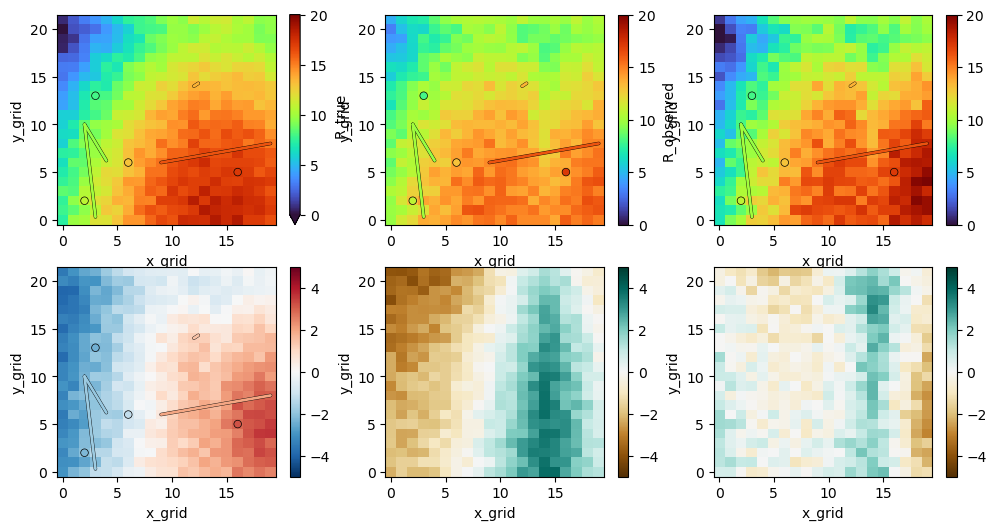

In [ ]:
merger = mrg.merge.MergeKrigingExternalDrift(min_observations=3)

R_grid_ked_high_level = merger.adjust(
    da_rad=ds_radar.R_observed.expand_dims('time').sel(time=[0]), # TODO, remove .sel once mergeplg is updated
    da_cml=ds_cmls.R.expand_dims('time'),
    da_gauge=ds_gauges.R.expand_dims('time'),
    variogram_parameters = {"sill": 1, "range": 20, "nugget": 0.1}
).isel(time=0)

plot_radar_fields_and_gauges(
    da_grid_R_true=ds_radar.R_true,
    da_grid_R_observed=ds_radar.R_observed,
    da_grid_R_adjusted=R_grid_ked_high_level,
    da_cmls_R=ds_cmls.R,
    da_gauges_R=ds_gauges.R,
    da_cmls_R_diff=ds_cmls.R_diff,
    da_gauges_R_diff=ds_gauges.R_diff,
)

In [ ]:
ds_radar.R_observed.data

array([[ 9.62034084, 11.36863923, 12.11979306, 13.82165433, 13.65972666,
        14.00120223, 14.69490996, 14.37884595, 15.29620648, 15.41695104,
        14.74658245, 15.72515042, 14.70390231, 14.75798169, 14.69402112,
        13.88862129, 15.90886089, 15.03515253, 15.69337063, 15.14836575],
       [ 9.72956444, 10.09028162, 11.14982414, 11.90877934, 13.94709729,
        13.18405115, 14.06337938, 16.15732834, 16.26076682, 15.66932919,
        15.33591049, 14.88627305, 14.88843114, 15.3770461 , 14.24456568,
        14.73274062, 14.63607248, 15.57157455, 15.90385019, 16.17329718],
       [ 9.56554562, 11.49143362, 13.01232472, 14.0481012 , 13.65652176,
        14.48218244, 13.94128667, 15.04097946, 14.43473341, 15.77567138,
        15.66417573, 15.66791288, 15.45594543, 13.68088458, 14.83302944,
        14.37217891, 15.43873855, 15.02317702, 16.39657111, 16.05218468],
       [10.32776403, 10.70800347, 12.49137099, 12.39679929, 12.543658  ,
        14.31161887, 14.33008125, 15.27087595, 1

In [ ]:
STOP HERE

SyntaxError: invalid syntax (3031286301.py, line 1)

In [ ]:
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg(data_dir="example_data")

ds_cmls = ds_cmls.rename_vars({'R': 'R_example'})

# Project data to coordinate system
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

ds_gauges_municp.coords["x"], ds_gauges_municp.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges_municp.lon, ds_gauges_municp.lat, ref_str
)

ds_gauge_smhi.coords["x"], ds_gauge_smhi.coords["y"] = (
    plg.spatial.project_point_coordinates(
        ds_gauge_smhi.lon, ds_gauge_smhi.lat, ref_str
    )
)

# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls.coords["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls.coords["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2


# Projected radar coords
ds_rad.coords["x_grid"], ds_rad.coords["y_grid"] = (
    plg.spatial.project_point_coordinates(ds_rad.lon, ds_rad.lat, ref_str)
)



File already exists at example_data/openmrg_cml_8d.nc
Not downloading!
File already exists at example_data/openmrg_rad_8d.nc
Not downloading!
File already exists at example_data/openmrg_municp_gauge_8d.nc
Not downloading!
File already exists at example_data/openmrg_smhi_gauge_8d.nc
Not downloading!


In [ ]:
# Get min/max bounds
offset = 4000 # meter
x_min = ds_gauges_municp.x.min() - offset
x_max = ds_gauges_municp.x.max() + offset
y_min = ds_gauges_municp.y.min() - offset
y_max = ds_gauges_municp.y.max() + offset

# Select small area radar
ds_rad_small = ds_rad.isel(
    x = np.where((ds_rad.x_grid < x_max).any(dim='y') & (ds_rad.x_grid > x_min).any(dim='y'))[0],
    y = np.where((ds_rad.y_grid < y_max).any(dim='x') & (ds_rad.y_grid > y_min).any(dim='x'))[0],
)

# Select small area CML
ds_cmls_small = ds_cmls.isel(cml_id = np.where(
        (ds_cmls.site_0_x < x_max) & (ds_cmls.site_1_x < x_max) & 
        (ds_cmls.site_0_x > x_min) & (ds_cmls.site_1_x > x_min) & 
        (ds_cmls.site_0_y < y_max) & (ds_cmls.site_1_y < y_max) & 
        (ds_cmls.site_0_y > y_min) & (ds_cmls.site_1_y > y_min)
    )[0]
)

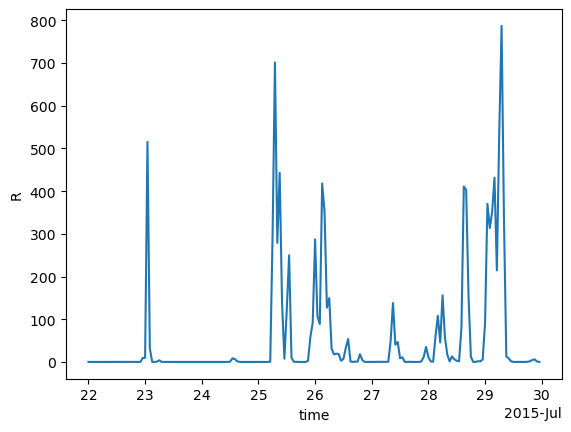

In [ ]:
R_rad_1h = ds_rad_small.R.resample(time='1h').mean()
R_rad_1h.sum(dim=['x', 'y']).plot()


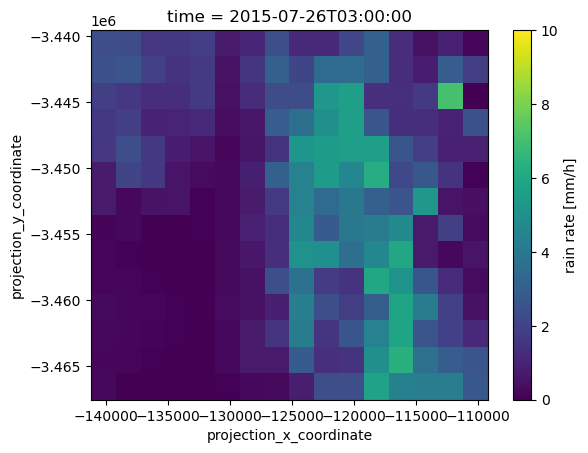

In [ ]:
t= '2015-07-26 03:00:00'
R_rad_1h.sel(time=t).plot(vmin=0, vmax=10)

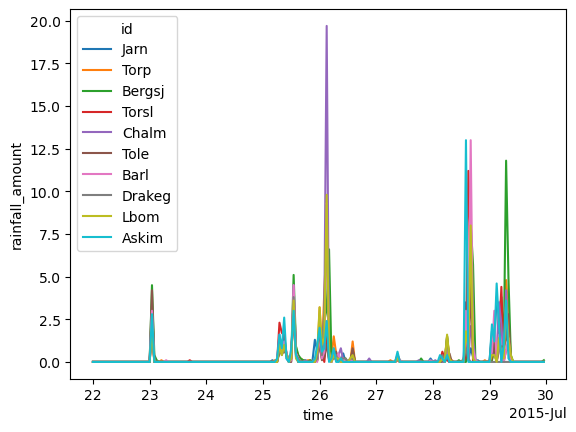

In [ ]:
R_gauges_1h = ds_gauges_municp.rainfall_amount.resample(time='1h').sum()
R_gauges_1h.plot.line(x='time');

(np.float64(657419.7641765462), np.float64(691161.0882478998))

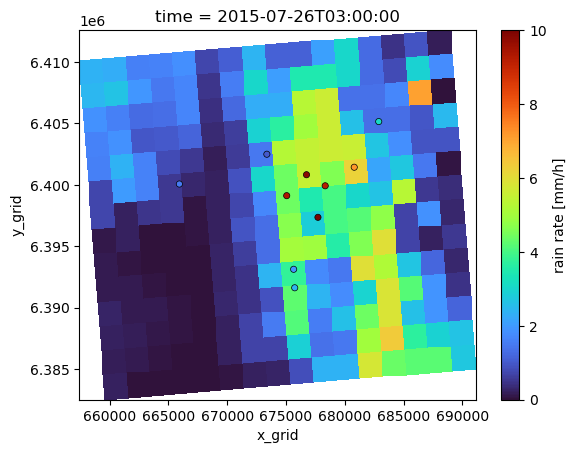

In [ ]:
t= '2015-07-26 03:00:00'

plg.plot_map.plot_plg(
    da_grid=R_rad_1h.sel(time=t),
    da_gauges=R_gauges_1h.sel(time=t),
    use_lon_lat=False,
    vmin=0,
    vmax=10,
)
plt.xlim()

In [ ]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad,
    da_point_data=ds_gauges_municp,
    nnear=1,
    use_lon_lat=True,
)

ds_gauges_municp['R_radar'] = get_grid_at_points(
    da_gridded_data=ds_rad.R,
    da_point_data=ds_gauges_municp.rainfall_amount,
)

In [ ]:
#R_rad_1h.sel(time=t).coords
#R_gauges_1h.sel(time=t)


In [ ]:
idw_interpolator = mrg.interpolate.InterpolateIDW()

R_grid_idw = idw_interpolator.interpolate(
            da_grid=R_rad_1h.sel(time=[t]),
            da_gauge=R_gauges_1h.sel(time=[t]),
        ).isel(time=0)

(np.float64(657419.7641765462), np.float64(691161.0882478998))

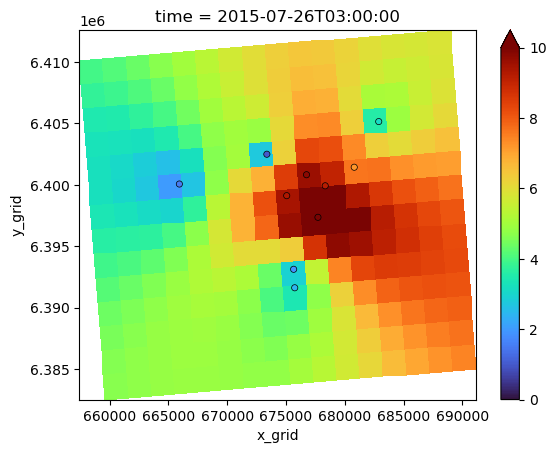

In [ ]:
t= '2015-07-26 03:00:00'

plg.plot_map.plot_plg(
    da_grid=R_grid_idw,
    da_gauges=R_gauges_1h.sel(time=t),
    use_lon_lat=False,
    vmin=0,
    vmax=10,
)
plt.xlim()

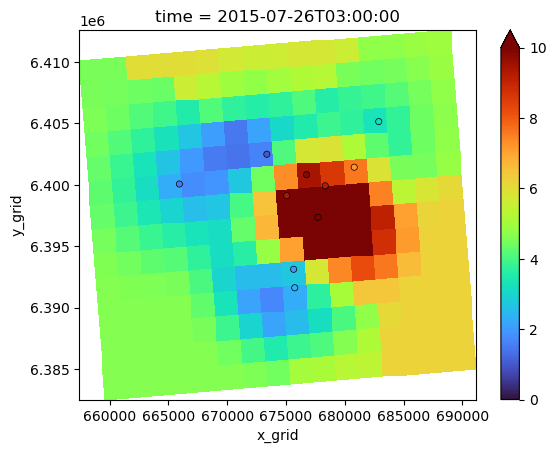

In [ ]:
#idw_interpolator = mrg.interpolate.InterpolateIDW(min_observations=2)
ok_interpolator = mrg.interpolate.InterpolateOrdinaryKriging(min_observations=2)

# R_grid_idw = ok_interpolator.interpolate(
#             da_grid=ds_radar.expand_dims('time'),
#             da_gauge=ds_gauges.R_diff.expand_dims('time'),
#         ).isel(time=0)

R_grid_idw = ok_interpolator.interpolate(
            da_grid=R_rad_1h.sel(time=[t]),
            #da_gauge=R_gauges_1h.sel(time=[t]).isel(id=slice(0, 4)),
            da_gauge=R_gauges_1h.sel(time=[t]),
            variogram_parameters = {"sill": 2, "range": 10000, "nugget": 0.2}
        ).isel(time=0)

t= '2015-07-26 03:00:00'

plg.plot_map.plot_plg(
    da_grid=R_grid_idw,
    #da_gauges=R_gauges_1h.sel(time=t).isel(id=slice(0, 4)),
    da_gauges=R_gauges_1h.sel(time=t),
    use_lon_lat=False,
    vmin=0,
    vmax=10,
);